<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [8]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import glob

In [21]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../data/'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [83]:
# Вырезаем ИД пользователя из имени файла
def get_user_id(filename):
    start_pos=(filename.find('\\user'))+5
    end_pos=(filename.find('.csv'))
    return int(filename[start_pos:end_pos])

# Взвращаем ИД сайта по его названию
def get_site_id(site,site_dict):
    return site_dict[site][0]



# Функция преобразовывает инфо по сессиям в таблицу признаков
def sessions_to_ftr(session_df,session_length,window_size,feature_names):
    # Создаем результирующий DataFrame
    ftr_df=pd.DataFrame(columns=feature_names)
    # Обходим каждого пользователя, по которому есть сессии
    for user in tqdm(session_df.user_id.value_counts().index):
        # Список сессий пользователя
        user_session=session_df[session_df.user_id==user]
        # Добавляем признаки по сессиям пользователmеля 
        add_ftr_from_usersession(ftr_df,user_session,session_length,user,window_size)
    return ftr_df

def convert_to_sparse(ar):
    def tokenizer(s):
        return list(s)
    vectorizer = CountVectorizer(analyzer=tokenizer)
    X = vectorizer.fit_transform(ar)
    X=X[:,1:]
    return X

# Добавляем в таблицу признаков инфо по сессиям пользователя 
def add_ftr_from_usersession(ftr_df,user_session_info,session_length,user_id,window_size):
    user_session_len=len(user_session_info)
    #print (user_session_info)
    start_pos=0
    doLoop=True
    while doLoop:
        session=user_session_info[start_pos:start_pos+session_length]
        site_id=session.site_id.values
        session_timespan=(session.timestamp.max()-session.timestamp.min()).total_seconds()
        unique_sites=len(np.unique(site_id))
        start_hour=session.timestamp.min().hour
        day_of_week=session.timestamp.min().weekday()
        if len(site_id)<session_length:
            site_id=np.lib.pad(site_id, (0,session_length-len(site_id)), 'constant', constant_values=(0))
        start_pos+=window_size
        if start_pos>=user_session_len:
            doLoop=False
        site_id=np.append(site_id,int(session_timespan))
        site_id=np.append(site_id,unique_sites)        
        site_id=np.append(site_id,start_hour)    
        site_id=np.append(site_id,day_of_week)    
        site_id=np.append(site_id,user_id)
        
        ftr_df.loc[len(ftr_df)]=site_id
        
# Функция возвращает подготовленные данные и словарь сайтов
def prepare_train_set_with_fe(path_to_csv_files,site_freq_path, feature_names,session_length=10,window_size=10):
    # Последовательно читаем все файлы сессий в каталоге и склеиваем их в один DataFrame
    sessions_df=pd.DataFrame()

    filelist=glob.glob(path_to_csv_files+'*.csv')
    for filename in filelist:
        df=pd.read_csv(filename)
        # Добавляем в сесии колонку с ИД пользователя 
        df['user_id']=get_user_id(filename)
        sessions_df=sessions_df.append(df)
    # Считаем частоту сайтов
    sessions_df['freq'] = sessions_df.groupby('site')['site'].transform('count')
    sessions_df.timestamp= pd.to_datetime(sessions_df.timestamp)
    # Формируем словарь сайтов
    pkl_file = open(site_freq_path, 'rb')
    site_dict=pickle.load(pkl_file)
    pkl_file.close()
    # Добавляем ИД сайта
    sessions_df['site_id']=sessions_df.site.apply(lambda x: get_site_id(x,site_dict))
    # Формируем результирующий DataFrame - набор признаков по сессиям
    ftr_df=sessions_to_ftr(sessions_df[['user_id','site_id','timestamp']],session_length,window_size,feature_names)  
    return ftr_df

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe('3users/', site_freq_path='site_freq_3users.pkl', feature_names=feature_names, session_length=10)
train_data_toy

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.13it/s]


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
3,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3
4,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2


**Проверим функцию на игрушечном примере.**

In [84]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe('3users/', site_freq_path='site_freq_3users.pkl', feature_names=feature_names, session_length=10)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 136.04it/s]


In [85]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
3,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3
4,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,4,2,2,11,2,1,8,5,9,10,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,4,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,5,7,3,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [86]:
%%time
train_data_10users = prepare_train_set_with_fe('10users/', site_freq_path='site_freq_10users.pkl', feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  4.57s/it]


Wall time: 56.8 s


In [87]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,4,216,10,21,4,65,27,27,4,70,7,13,4,128
1,10,21,65,4,30,6,9,30,9,6,2,7,13,4,128
2,3,9,3,6,10,4,4,33,115,9,3,7,13,4,128
3,9,33,9,6,9,4,4,115,4,4,148,5,13,4,128
4,1446,41,41,82,82,3,33,1446,41,41,157,5,13,4,128


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [88]:
%%time
train_data_150users = prepare_train_set_with_fe('150users/', site_freq_path='site_freq_150users.pkl', feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [1:17:10<00:00, 24.69s/it]


Wall time: 1h 17min 16s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [93]:
new_features_10users = train_data_10users.iloc[:,10:-1]
new_features_150users = train_data_150users.iloc[:,10:-1]

In [94]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [138]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [139]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

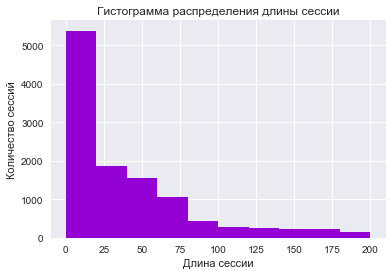

In [115]:
plt.hist(train_data_10users['session_timespan'],color='darkviolet',range=[0,200])
plt.title('Гистограмма распределения длины сессии')
plt.ylabel('Количество сессий')
plt.xlabel('Длина сессии')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

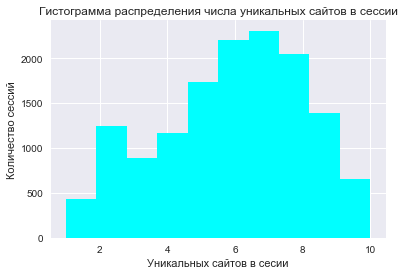

In [117]:
plt.hist(train_data_10users['#unique_sites'],color='aqua')
plt.title('Гистограмма распределения числа уникальных сайтов в сессии')
plt.ylabel('Количество сессий')
plt.xlabel('Уникальных сайтов в сесии')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

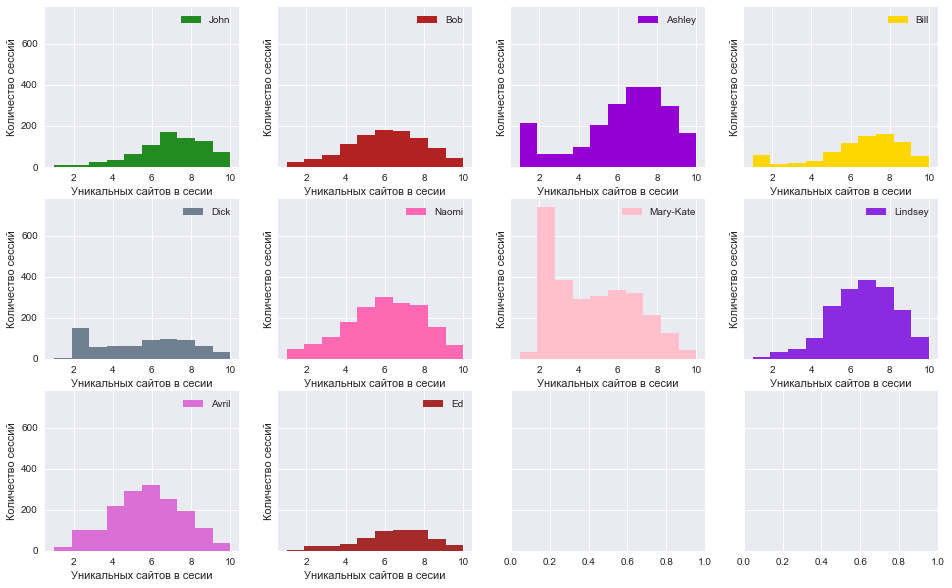

In [224]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10),sharey=True)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    row,col=int(idx/4),idx%4
    username=id_name_dict[user]
    axes[row,col].set_ylabel('Количество сессий')
    axes[row,col].set_xlabel('Уникальных сайтов в сесии')
    axes[row,col].hist(sub_df['#unique_sites'],color=color_dic[username], label=username)
    axes[row,col].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

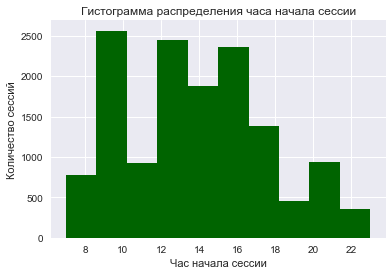

In [158]:
plt.hist(train_data_10users['start_hour'] ,color='darkgreen')
plt.title('Гистограмма распределения часа начала сессии')
plt.ylabel('Количество сессий')
plt.xlabel('Час начала сессии')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

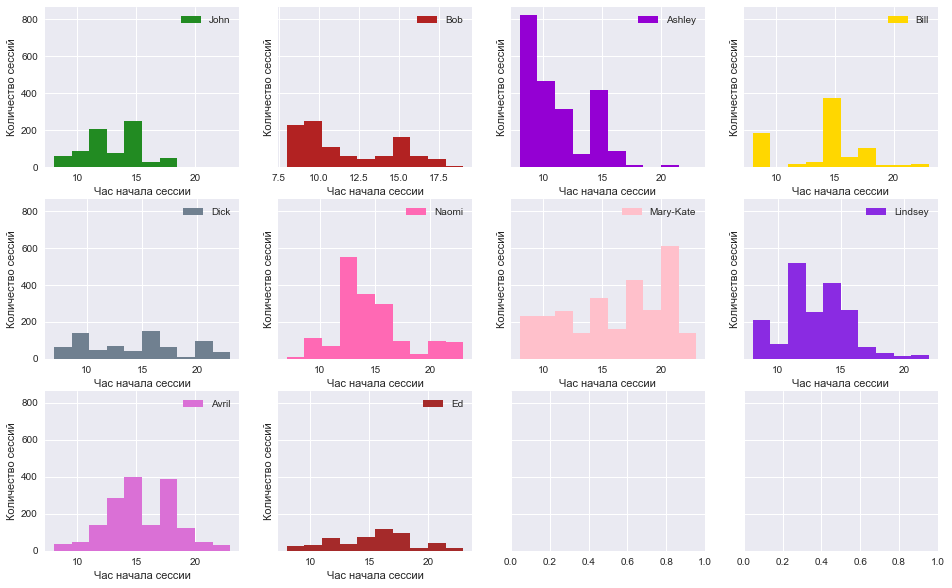

In [223]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10),sharey=True)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    row,col=int(idx/4),idx%4
    username=id_name_dict[user]
    axes[row,col].set_ylabel('Количество сессий')
    axes[row,col].set_xlabel('Час начала сессии')
    axes[row,col].hist(sub_df['start_hour'],color=color_dic[username], label=username)
    axes[row,col].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

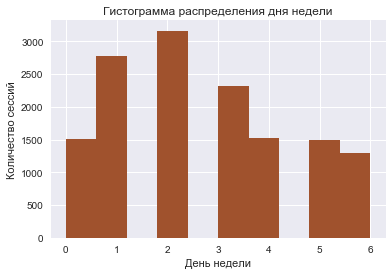

In [161]:
plt.hist(train_data_10users['day_of_week'] ,color='sienna')
plt.title('Гистограмма распределения дня недели')
plt.ylabel('Количество сессий')
plt.xlabel('День недели')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

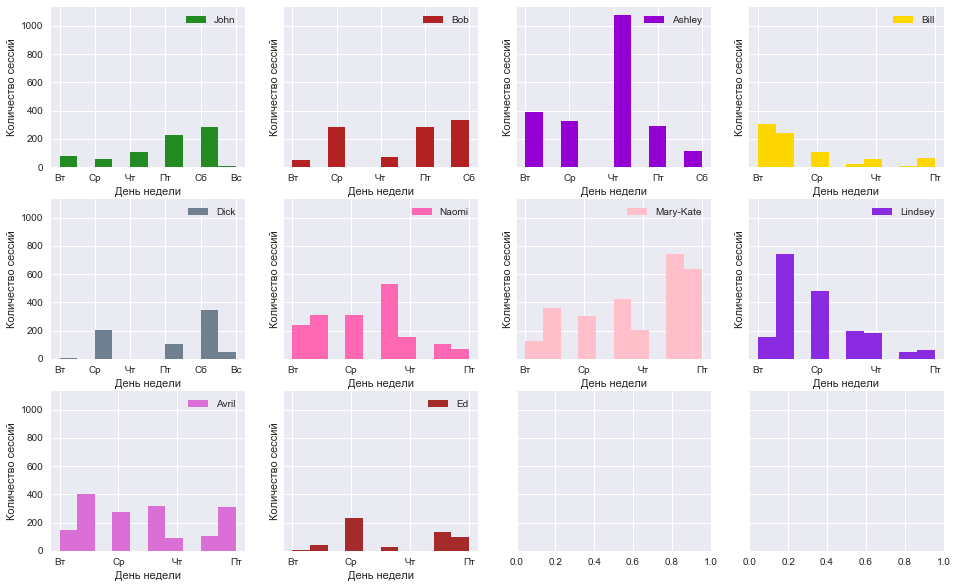

In [222]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10),sharey=True)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    row,col=int(idx/4),idx%4
    username=id_name_dict[user]
    axes[row,col].set_xlabel('День недели')
    axes[row,col].set_ylabel('Количество сессий')
    axes[row,col].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] )
    axes[row,col].hist(sub_df['day_of_week'],color=color_dic[username], label=username)
    axes[row,col].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Большинство пользователей посещает 6-8 сайтов в сессию. Исключеня - Dick,Mary-Cane,

В основном люди неравномерно выходят в интрнет в течении недели.
Наибольшее количество полсещений приходится:

* John - пятница, суббота
* Bob - Среда, суббота, вскр
* Ashli - Чтв
* bill- Пн, Вт
* Dick - Среда, суббота
* Naomi - Чтв
* Mary-kate= суббота, вскр
* Lidsey - Вт
* Avril - в течении всей недели
* Ed - Среда, суббота,вскр

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [173]:
with open('site_freq_10users.pkl', 'rb') as pkl_file:
    site_dict=pickle.load(pkl_file)
site_dict

{'passets.pinterest.com': (963, 11),
 'recrutement.talentup.com': (2577, 2),
 'www.gamehdwall.com': (1697, 5),
 'www.netbeans.org': (2844, 2),
 'www.luminate.com': (2283, 3),
 'www.woodbrass.com': (1319, 7),
 'thesasreference.files.wordpress.com': (3865, 1),
 'd13pix9kaak6wt.cloudfront.net': (4869, 1),
 'sriramoracle.files.wordpress.com': (3162, 2),
 'www.maboutiqueregimedukan.com': (2818, 2),
 'f.dailymail.co.uk': (3881, 1),
 'geoguessr.com': (2255, 3),
 'fec.linternaute.com': (3578, 1),
 'enquete.consoglobe.com': (2667, 2),
 'clic.reussissonsensemble.fr': (1806, 4),
 'ea.pixmania.fr': (1257, 7),
 'd2hfi8wofzzjwf.cloudfront.net': (3150, 2),
 'perso.ens-lyon.fr': (3450, 1),
 'www.unige.ch': (2784, 2),
 'cdn1.developermedia.com': (2035, 4),
 'static.olark.com': (1190, 8),
 'books.google.com': (746, 16),
 'sjc.sl.bench.cedexis.com': (1472, 6),
 'www.tizag.com': (1775, 5),
 'www.silverdisc.com': (3925, 1),
 'it3yv1v73b.s.ad6media.fr': (760, 16),
 'i2.services.social.microsoft.com': (2227,

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [199]:
site_dict_df=pd.DataFrame.from_dict(site_dict,orient='index')
site_dict_df.columns=['id','freq']
site_dict_df.sort_values('freq',ascending=False,inplace=True)
site_dict_df=site_dict_df.iloc[:10,:]
top10_freqs = site_dict_df.freq.as_matrix()
top10_sites =  site_dict_df.index.values

array(['s.youtube.com', 'www.google.fr', 'www.google.com',
       'mail.google.com', 'www.facebook.com', 'apis.google.com',
       'r3---sn-gxo5uxg-jqbe.googlevideo.com',
       'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com',
       'accounts.google.com'], dtype=object)

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

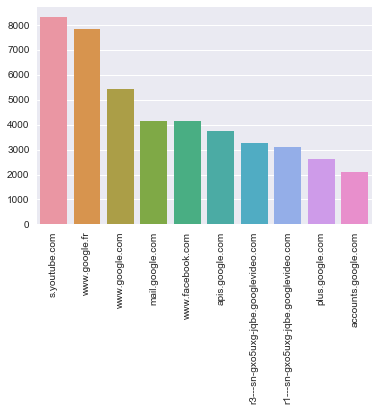

In [219]:
sns.barplot(top10_sites,top10_freqs)
plt.xticks( rotation='vertical')
plt.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [206]:
new_features_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [207]:
new_features_10users.day_of_week.median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [210]:
new_features_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [213]:
new_features_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [267]:
# Вырезаем ИД пользователя из имени файла
def get_user_id(filename):
    start_pos=(filename.find('\\user'))+5
    end_pos=(filename.find('.csv'))
    return int(filename[start_pos:end_pos])

# Взвращаем ИД сайта по его названию
def get_site_id(site,site_dict):
    return site_dict[site][0]



# Функция преобразовывает инфо по сессиям в таблицу признаков
def sessions_to_ftr(session_df,session_length,window_size,feature_names):
    # Создаем результирующий DataFrame
    ftr_df=pd.DataFrame(columns=feature_names)
    # Обходим каждого пользователя, по которому есть сессии
    for user in tqdm(session_df.user_id.value_counts().index):
        # Список сессий пользователя
        user_session=session_df[session_df.user_id==user]
        # Добавляем признаки по сессиям пользователmеля 
        add_ftr_from_usersession(ftr_df,user_session,session_length,user,window_size)
    return ftr_df

def convert_to_sparse(ar):
    def tokenizer(s):
        return list(s)
    vectorizer = CountVectorizer(analyzer=tokenizer)
    X = vectorizer.fit_transform(ar)
    X=X[:,1:]
    return X

# Добавляем в таблицу признаков инфо по сессиям пользователя 
def add_ftr_from_usersession(ftr_df,user_session_info,session_length,user_id,window_size):
    popular=get_popular(user_session_info)
    user_session_len=len(user_session_info)
    #print (user_session_info)
    start_pos=0
    doLoop=True
    while doLoop:
        session=user_session_info[start_pos:start_pos+session_length]
        site_id=session.site_id.values
        session_timespan=(session.timestamp.max()-session.timestamp.min()).total_seconds()
        unique_sites=len(np.unique(site_id))
        start_hour=session.timestamp.min().hour
        day_of_week=session.timestamp.min().weekday()
        inter = np.intersect1d(site_id,popular)
        pop=0
        if len(inter)>0:
            pop=1
        if len(site_id)<session_length:
            site_id=np.lib.pad(site_id, (0,session_length-len(site_id)), 'constant', constant_values=(0))
        start_pos+=window_size
        if start_pos>=user_session_len:
            doLoop=False
        site_id=np.append(site_id,int(session_timespan))
        site_id=np.append(site_id,unique_sites)        
        site_id=np.append(site_id,start_hour)    
        site_id=np.append(site_id,day_of_week)    
        site_id=np.append(site_id,pop)
        site_id=np.append(site_id,user_id)
        
        ftr_df.loc[len(ftr_df)]=site_id
# Возвращает top популярных сайта пользователя
def get_popular(sessions,top=30):
    top_sites=sessions.site_id.value_counts()
    top_sites.sort_values(inplace=True,ascending=False)
    top_sites=top_sites[:top].index.values
    return top_sites
    
# Функция возвращает подготовленные данные и словарь сайтов
def feature_engineering(path_to_csv_files,site_freq_path, feature_names,session_length=10,window_size=10):
    # Последовательно читаем все файлы сессий в каталоге и склеиваем их в один DataFrame
    sessions_df=pd.DataFrame()

    filelist=glob.glob(path_to_csv_files+'*.csv')
    for filename in filelist:
        df=pd.read_csv(filename)
        # Добавляем в сесии колонку с ИД пользователя 
        df['user_id']=get_user_id(filename)
        sessions_df=sessions_df.append(df)
    # Считаем частоту сайтов
    sessions_df['freq'] = sessions_df.groupby('site')['site'].transform('count')
    sessions_df.timestamp= pd.to_datetime(sessions_df.timestamp)
    # Формируем словарь сайтов
    pkl_file = open(site_freq_path, 'rb')
    site_dict=pickle.load(pkl_file)
    pkl_file.close()
    # Добавляем ИД сайта
    sessions_df['site_id']=sessions_df.site.apply(lambda x: get_site_id(x,site_dict))
    # Формируем результирующий DataFrame - набор признаков по сессиям
    ftr_df=sessions_to_ftr(sessions_df[['user_id','site_id','timestamp']],session_length,window_size,feature_names)  
    return ftr_df

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'pop','user_id']
train_data_toy  = feature_engineering('3users/', site_freq_path='site_freq_3users.pkl', feature_names=feature_names, session_length=10)
train_data_toy

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 103.13it/s]


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,pop,user_id
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1,1
2,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,1,3
3,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,1,3
4,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,1,2


In [268]:
new_features_10users = feature_engineering('10users/', site_freq_path='site_freq_10users.pkl', feature_names=feature_names, session_length=10)
new_features_10users.head(20)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  4.70s/it]


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,pop,user_id
0,192,4,216,10,21,4,65,27,27,4,70,7,13,4,1,128
1,10,21,65,4,30,6,9,30,9,6,2,7,13,4,1,128
2,3,9,3,6,10,4,4,33,115,9,3,7,13,4,1,128
3,9,33,9,6,9,4,4,115,4,4,148,5,13,4,1,128
4,1446,41,41,82,82,3,33,1446,41,41,157,5,13,4,1,128
5,82,41,41,165,787,97,787,99,787,97,42,6,13,4,0,128
6,1395,187,99,44,95,41,44,159,215,9,67,9,13,4,1,128
7,44,115,21,9,3,65,155,10,2,27,3,10,13,4,1,128
8,787,97,100,100,250,233,79,100,79,233,20,6,13,4,0,128
9,233,233,233,100,100,233,100,79,79,79,8,3,13,4,0,128


In [269]:
new_features_150users = feature_engineering('150users/', site_freq_path='site_freq_150users.pkl', feature_names=feature_names, session_length=10)
new_features_150users.head(20)

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [1:25:00<00:00, 29.60s/it]


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,pop,user_id
0,61,61,352,109,48,726,109,20,9,48,102,7,8,2,1,583
1,468,7,6,45,6,6,6,1,1352,2,34,7,8,2,1,583
2,6,1352,49,49,42,8,56,57,4,2,174,9,8,2,1,583
3,51,680,7,46,14,319,2,1,6,45,364,10,8,2,1,583
4,6,1,2759,6,128,986,319,2759,2759,2759,16,6,8,2,1,583
5,612,54,986,986,40,1,32,40,52,32,3,7,8,2,1,583
6,57,57,986,52,31,3320,6,986,319,319,4,7,8,2,1,583
7,986,319,612,612,20,9,9,32,40,123,56,8,8,2,1,583
8,31,2,4,1,23,1,2759,612,2759,986,166,8,8,2,1,583
9,986,3320,986,319,612,612,612,349,349,4012,12,6,8,2,0,583


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

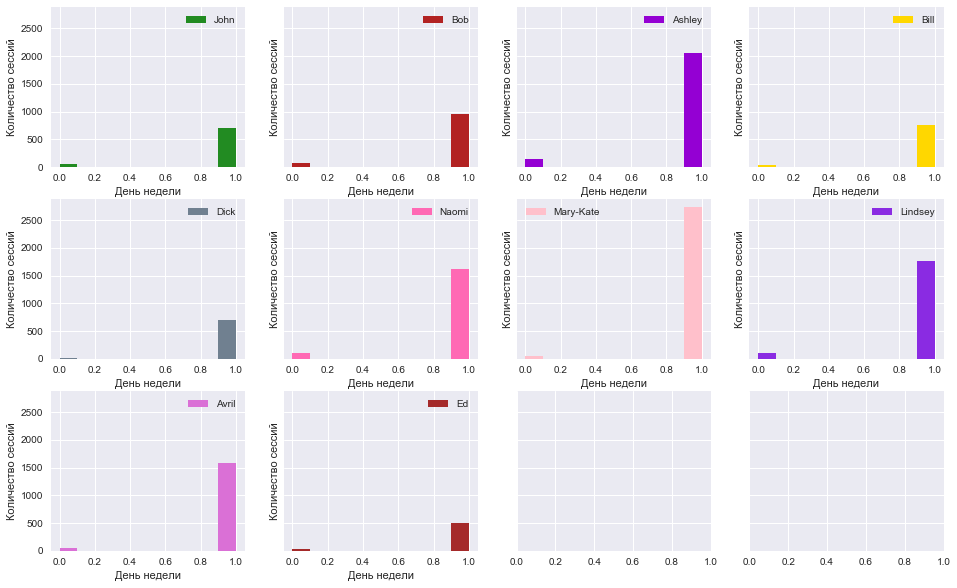

In [276]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10),sharey=True)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    row,col=int(idx/4),idx%4
    username=id_name_dict[user]
    axes[row,col].set_xlabel('День недели')
    axes[row,col].set_ylabel('Количество сессий')
    axes[row,col].hist(sub_df['pop'],color=color_dic[username], label=username)
    axes[row,col].legend()


Видно что пользователи постоянно заходят на одни и те же сайты

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 